Mounted at /content/drive
Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 358s 8s/step - accuracy: 0.4263 - loss: 20.4764 - val_accuracy: 0.4500 - val_loss: 15.7794 - learning_rate: 0.0010
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4986 - loss: 14.4997 - val_accuracy: 0.4400 - val_loss: 11.7913 - learning_rate: 0.0010
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 998ms/step - accuracy: 0.5926 - loss: 10.6911 - val_accuracy: 0.5300 - val_loss: 8.7319 - learning_rate: 0.0010
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5808 - loss: 8.2031 - val_accuracy: 0.5833 - val_loss: 6.7451 - learning_rate: 0.0010
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 950ms/step - accuracy: 0.5571 - loss: 6.4117 - val_accuracy: 0.5600 - val_loss: 5.5293 - learning_rate: 0.0010
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 953ms/step - accuracy: 0.5830 - loss: 5.1570 - val_accuracy: 0.5133 - val_loss: 4.5035 - learning_rate: 0.0010
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 965ms/step - accuracy: 0.6312 - loss: 4.1548 - val_acc

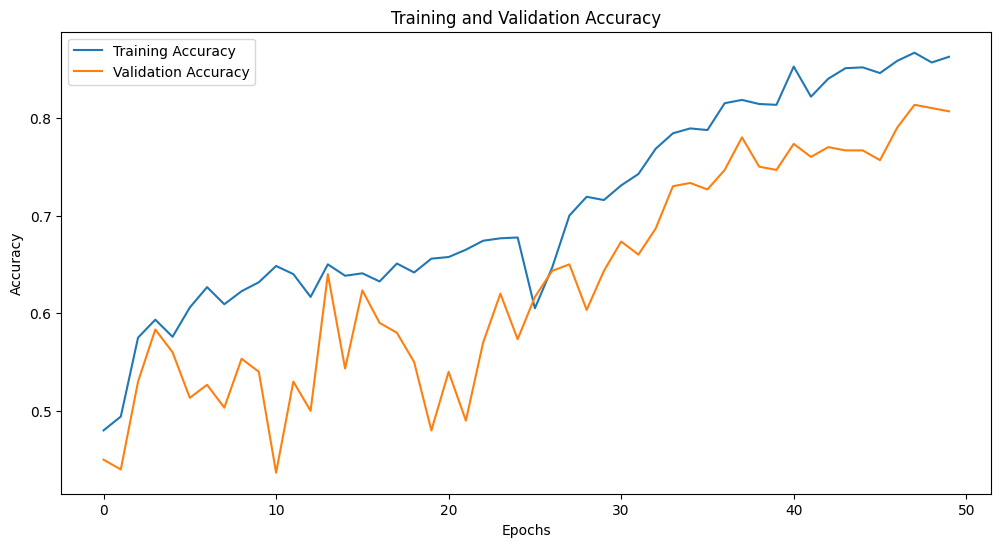

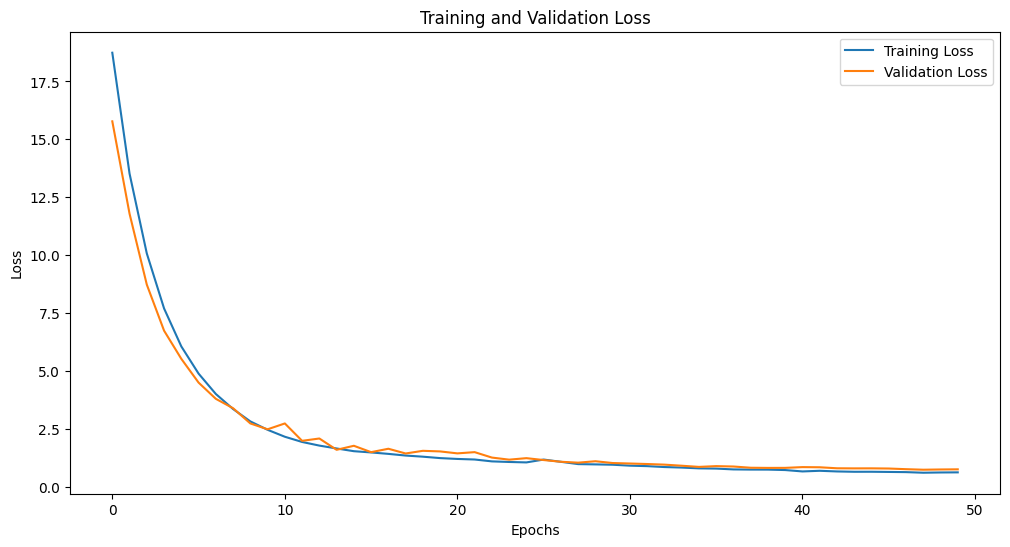

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset directory path
dataset_path = '/content/drive/MyDrive/sinusities/sinusities_dataset'

# Enhanced Dataset Preprocessing with More Augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Load Pre-Trained InceptionV3 Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Build Custom Layers on Top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)          # Dropout to reduce overfitting
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)          # Additional Dropout for regularization
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze Base Model Layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the Model with a Warm-Up Learning Rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Start with a high learning rate for warm-up
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for Training
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )
]

# Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,  # Fewer epochs for warm-up
    callbacks=callbacks
)

# Fine-Tune the Model
# Gradually Unfreeze Layers for Fine-Tuning
for layer in base_model.layers[:249]:
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True

# Recompile with a Lower Learning Rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Fine-Tuned Model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=callbacks
)

# Save the Model
model.save('/content/drive/MyDrive/sinusities/inceptionV3_updated.h5')

# Combine Histories for Visualization
history.history['accuracy'].extend(fine_tune_history.history['accuracy'])
history.history['val_accuracy'].extend(fine_tune_history.history['val_accuracy'])
history.history['loss'].extend(fine_tune_history.history['loss'])
history.history['val_loss'].extend(fine_tune_history.history['val_loss'])

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
